# Data ingestion and visualization

Name: Sunny Gupta

Date: 4/2/2025

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import verde as vd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import geopandas as gpd
from pyproj import CRS, Transformer
from tqdm.auto import tqdm
import harmonica as hm
import time
from bouguer import *

In [2]:
# Open BedMachine|
bm = xr.open_dataset("cryo_share/BedMachineAntarctica-v3.nc")

## With BedMachine open, we now trim BedMachine to our area of interest
For me, this is Western Queen Maud Land, particularly focusing on the Jelbart and Fimbul ice shelves.



In [3]:
# Using BedMap, I found a given midpoint Western Queen Maud Land (i.e., Ekstrom, Jelbart, and Fimbul):
x_center = -36641.323934
y_center = 2099180.042265

# Create Python slice to get values in a 375km range from this centerpoint. Then we apply these slices to the bm dataset
x_slice = slice(x_center - 375000, x_center + 375000)
y_slice = slice(y_center + 375000, y_center - 375000)


subset = bm.sel(x=x_slice, y=y_slice)

## Basic Plot of this Subset



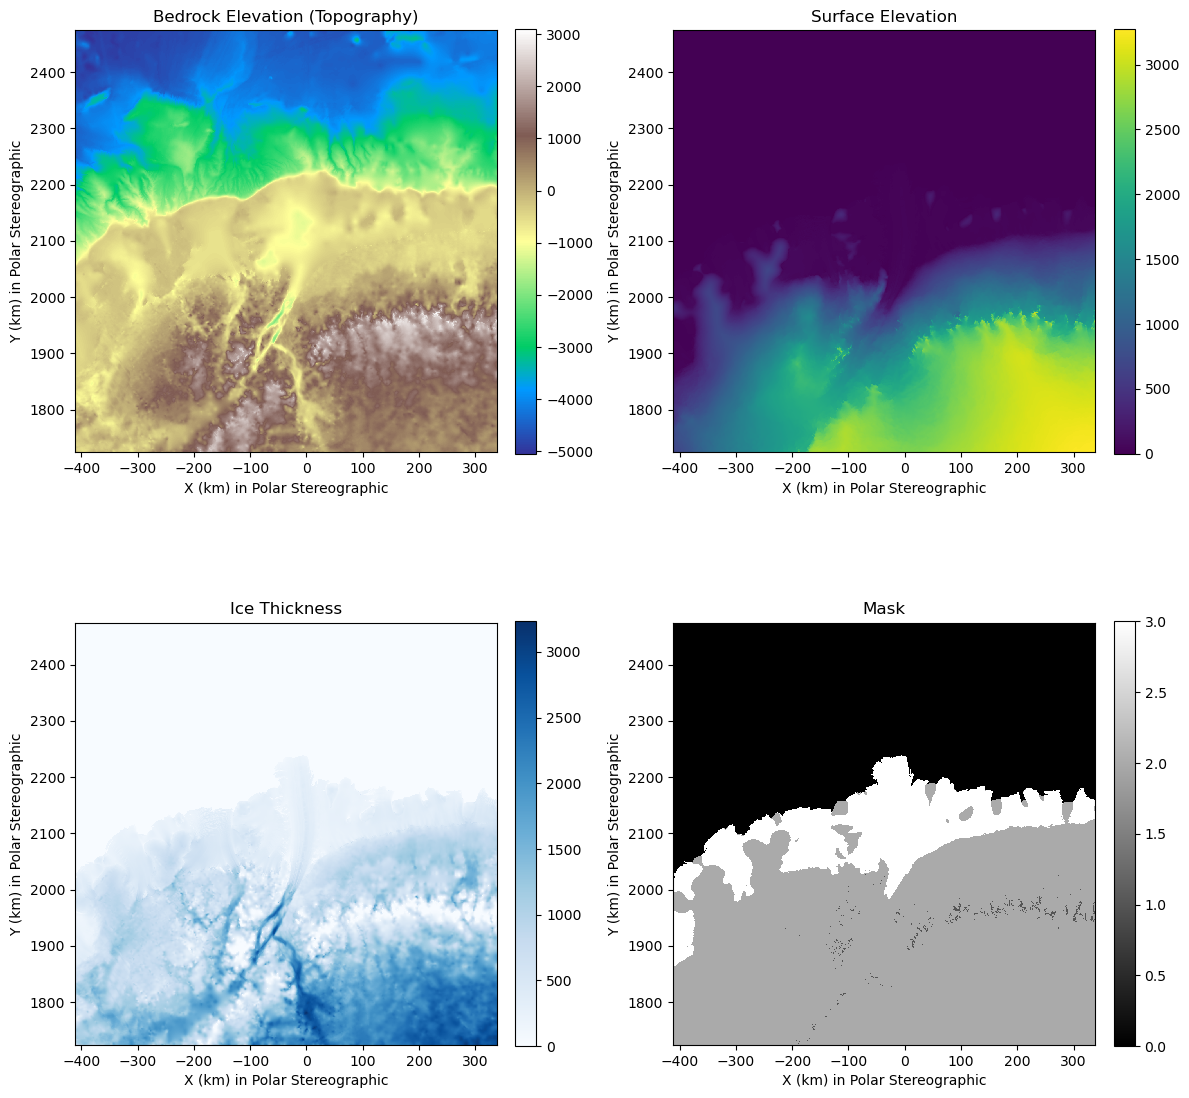

In [4]:
################################
# Convert data to km for ease in plotting/scale
x_km = subset["x"] / 1000  
y_km = subset["y"] / 1000  

# Save data into clear variables for plotting
bed = subset["bed"]
surface = subset["surface"]
thickness = subset["thickness"]
mask = subset["mask"]

# Create a figure with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot the bed elevation
bed_plot = axs[0, 0].pcolormesh(x_km, y_km, bed, cmap="terrain", shading="auto")
axs[0, 0].axis("scaled")
axs[0, 0].set_title("Bedrock Elevation (Topography)")
axs[0, 0].set_xlabel("X (km) in Polar Stereographic")
axs[0, 0].set_ylabel("Y (km) in Polar Stereographic")
fig.colorbar(bed_plot, ax=axs[0, 0], fraction=0.046, pad=0.04)

# Plot the surface elevation
surface_plot = axs[0, 1].pcolormesh(x_km, y_km, surface, cmap="viridis", shading="auto")
axs[0, 1].axis("scaled")
axs[0, 1].set_title("Surface Elevation")
axs[0, 1].set_xlabel("X (km) in Polar Stereographic")
axs[0, 1].set_ylabel("Y (km) in Polar Stereographic")
fig.colorbar(surface_plot, ax=axs[0, 1], fraction=0.046, pad=0.04)

# Plot the ice thickness
thickness_plot = axs[1, 0].pcolormesh(x_km, y_km, thickness, cmap="Blues", shading="auto")
axs[1, 0].axis("scaled")
axs[1, 0].set_title("Ice Thickness")
axs[1, 0].set_xlabel("X (km) in Polar Stereographic")
axs[1, 0].set_ylabel("Y (km) in Polar Stereographic")
fig.colorbar(thickness_plot, ax=axs[1, 0], fraction=0.046, pad=0.04)

# Plot the mask (shows us what's ice, water, etc.)
mask_plot = axs[1, 1].pcolormesh(x_km, y_km, mask, cmap="gray", shading="auto")
axs[1, 1].axis("scaled")
axs[1, 1].set_title("Mask")
axs[1, 1].set_xlabel("X (km) in Polar Stereographic")
axs[1, 1].set_ylabel("Y (km) in Polar Stereographic")
fig.colorbar(mask_plot, ax=axs[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Coarsening the data with a block reduction 

This data is at ~500m resolution, which is prohibitively high (data of this size cannot be easily shared on sites like GitHub and processing code expends significantly higher resources). For this reason, we coarsen the data. The data is now 300x300, with 2500m spacing between datapoints.

In [5]:
from scipy.stats import mode

def mode_custom(a):
    vals = mode(a)
    return vals[0].squeeze()

In [6]:
# Coarsen the data by 5x5 blocks using the mean
coarsenedSubset = subset.coarsen(x=5, y=5).mean()
# Coarsen the data again but by median, and store this in a separate location
coarsenedMask = subset.coarsen(x=5, y=5).median()
# Take the mask of the median coarse and make that the mask of the mean-coarsed subset to give mask discrete values
coarsenedSubset["mask"] = coarsenedMask["mask"]

In [7]:
# Make sure surface is 0 in open water
coarsenedSubset['surface'] = (('y', 'x'), np.where(coarsenedSubset.mask==0, 0, coarsenedSubset.surface))

# Make sure thickness is 0 in open water and at exposed rock
ocean_rock_msk = (coarsenedSubset.mask==0)^(coarsenedSubset.mask==1)
coarsenedSubset['thickness'] = (('y', 'x'), np.where(ocean_rock_msk, 0, coarsenedSubset.thickness))

# Make sure bed is equal to surface minus thickness under grounded ice
coarsenedSubset['bed'] = (('y', 'x'), np.where(coarsenedSubset.mask==2, coarsenedSubset.surface-coarsenedSubset.thickness, coarsenedSubset.bed))

# Make sure surface is equal to bed at exposed rock
coarsenedSubset['bed'] = (('y', 'x'), np.where(coarsenedSubset.mask==1, coarsenedSubset.surface, coarsenedSubset.bed))

# Make sure bed not above ice in ice shelf
bed_above_ice_bottom = np.where(coarsenedSubset.bed > (coarsenedSubset.surface-coarsenedSubset.thickness), True, False)
coarsenedSubset['bed'] = (('y', 'x'), np.where(bed_above_ice_bottom, coarsenedSubset.surface-coarsenedSubset.thickness, coarsenedSubset.bed))

# Make mask grounded ice where bed was above ice bottom
coarsenedSubset['mask'] = (('y', 'x'), np.where(bed_above_ice_bottom, 2, coarsenedSubset.mask))

## Now remake the previous figure with the coarsened data

In [8]:
coarsenedSubset

<xarray.Dataset> Size: 5MB
Dimensions:    (y: 300, x: 300)
Coordinates:
  * x          (x) float64 2kB -4.105e+05 -4.08e+05 ... 3.345e+05 3.37e+05
  * y          (y) float64 2kB 2.473e+06 2.47e+06 ... 1.728e+06 1.726e+06
Data variables:
    mapping    |S1 1B b''
    mask       (y, x) float64 720kB 0.0 0.0 0.0 0.0 0.0 ... 2.0 2.0 2.0 2.0 2.0
    firn       (y, x) float32 360kB 0.0 0.0 0.0 0.0 ... 27.87 27.9 27.91 27.91
    surface    (y, x) float32 360kB 0.0 0.0 0.0 ... 3.274e+03 3.274e+03
    thickness  (y, x) float32 360kB 0.0 0.0 0.0 ... 2.855e+03 2.911e+03
    bed        (y, x) float32 360kB -4.844e+03 -4.815e+03 ... 418.4 363.1
    errbed     (y, x) float32 360kB nan nan nan nan ... 40.12 35.4 39.84 74.44
    source     (y, x) float64 720kB 1.0 1.0 1.0 1.0 1.0 ... 5.0 5.0 5.0 5.0 5.0
    dataid     (y, x) float64 720kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.32 0.0 0.0
    geoid      (y, x) float64 720kB 7.0 7.0 7.0 7.0 7.0 ... 16.0 16.0 16.0 16.0
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

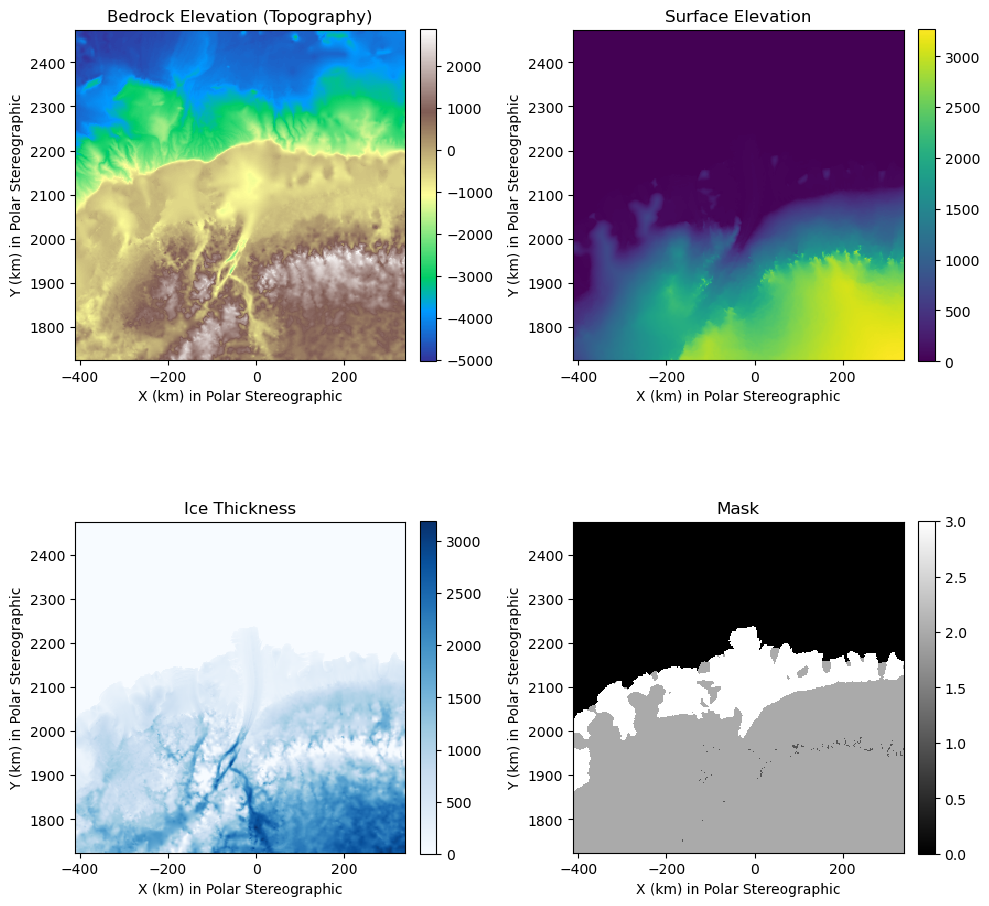

In [9]:
x_km_coarsened = coarsenedSubset["x"] / 1000  
y_km_coarsened = coarsenedSubset["y"] / 1000  

coarsened_bed = coarsenedSubset["bed"]
coarsened_surface = coarsenedSubset["surface"]
coarsened_thickness = coarsenedSubset["thickness"]
coarsened_mask = coarsenedSubset["mask"]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the bed
bed_plot = axs[0, 0].pcolormesh(x_km_coarsened, y_km_coarsened, coarsened_bed, cmap="terrain", shading="auto")
axs[0, 0].axis("scaled")
axs[0, 0].set_title("Bedrock Elevation (Topography)")
axs[0, 0].set_xlabel("X (km) in Polar Stereographic")
axs[0, 0].set_ylabel("Y (km) in Polar Stereographic")
fig.colorbar(bed_plot, ax=axs[0, 0], fraction=0.046, pad=0.04)

# Plot the surface
surface_plot = axs[0, 1].pcolormesh(x_km_coarsened, y_km_coarsened, coarsened_surface, cmap="viridis", shading="auto")
axs[0, 1].axis("scaled")
axs[0, 1].set_title("Surface Elevation")
axs[0, 1].set_xlabel("X (km) in Polar Stereographic")
axs[0, 1].set_ylabel("Y (km) in Polar Stereographic")
fig.colorbar(surface_plot, ax=axs[0, 1], fraction=0.046, pad=0.04)

# Plot the thickness
thickness_plot = axs[1, 0].pcolormesh(x_km_coarsened, y_km_coarsened, coarsened_thickness, cmap="Blues", shading="auto")
axs[1, 0].axis("scaled")
axs[1, 0].set_title("Ice Thickness")
axs[1, 0].set_xlabel("X (km) in Polar Stereographic")
axs[1, 0].set_ylabel("Y (km) in Polar Stereographic")
fig.colorbar(thickness_plot, ax=axs[1, 0], fraction=0.046, pad=0.04)

# Plot the mask
mask_plot = axs[1, 1].pcolormesh(x_km_coarsened, y_km_coarsened, coarsened_mask, cmap="gray", shading="auto")
axs[1, 1].axis("scaled")
axs[1, 1].set_title("Mask")
axs[1, 1].set_xlabel("X (km) in Polar Stereographic")
axs[1, 1].set_ylabel("Y (km) in Polar Stereographic")
fig.colorbar(mask_plot, ax=axs[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Part 2: Gravity Data

Ingesting and visualizing Gravity Data

In [10]:
# Formerly, my dataset included more of Eisermann et al.'s work in Ekstorm, but that is no longer included
# as there appear to be anomalies in that data.
visa = pd.read_table(Path("cryo_share/eisermann/Eisermann_et_al_2020_GRL_RawGrav_VISA.XYZ"), sep="\s+", skiprows=15, names=["lat", "lon", "height", "faa", "raw"])

transformer = Transformer.from_crs(4326, 3031)
visa.faa.isna().sum()
x_visa, y_visa = transformer.transform(visa.lat, visa.lon)

visa["x"] = x_visa
visa["y"] = y_visa

# Let's get rid of outliers that are too low
visa = visa[visa.faa > -200]

# Read images of the coast and grounding line for visual reference
moa_coast=gpd.read_file(Path("cryo_share/moa/coastlines/moa2014_coastline_v01.shp"))
moa_gl=gpd.read_file(Path("cryo_share/moa/coastlines/moa2014_grounding_line_v01.shp"))
moa_islands = gpd.read_file(Path("cryo_share/moa/coastlines/moa2014_islands_v01.shp"))

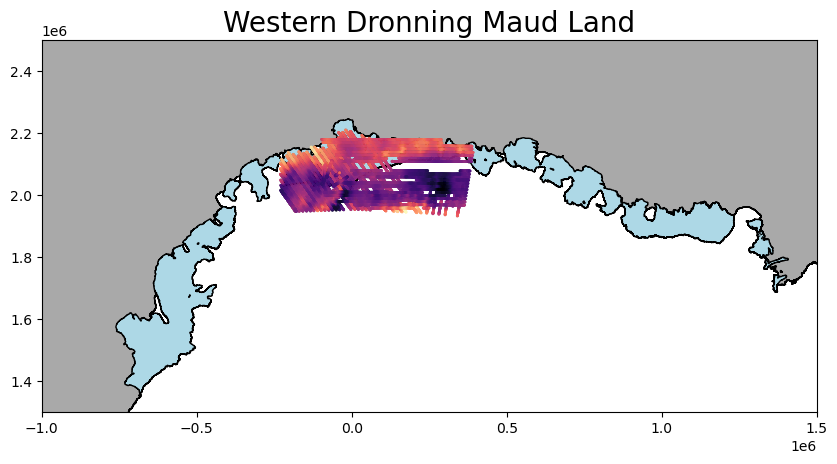

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_facecolor('darkgray')
moa_coast.plot(facecolor='lightblue', edgecolor='k', ax=ax)
moa_gl.plot(facecolor='white', edgecolor='k', ax=ax)
moa_islands.plot(facecolor='white', edgecolor='k', ax=ax)
ax.scatter(visa.x, visa.y, c=visa.faa, s=1, cmap='magma', alpha=0.1)
ax.axis('scaled')
ax.set_xlim([-1e6, 1.5e6])
ax.set_ylim([1.3e6, 2.5e6])
ax.set_title('Western Dronning Maud Land', fontsize=20)
plt.show()

In [12]:
# We only really need the Free-Air Anomalies and the X and Y coordinates

In [13]:
visa = visa.drop(["raw", "lat", "lon"], axis = 1)
visa

,height,faa,x,y
0,3272.04,-23.13,-229475.914366,2.032358e+06
1,3271.82,-23.49,-229428.683689,2.032296e+06
2,3271.65,-23.85,-229381.455534,2.032234e+06
3,3271.56,-24.21,-229334.584584,2.032172e+06
4,3271.60,-24.57,-229287.236484,2.032109e+06
...,...,...,...,...
209791,4066.42,-3.90,-86373.731467,1.998761e+06
209792,4066.42,-3.70,-86458.345456,1.998761e+06
209793,4066.50,-3.50,-86542.610817,1.998762e+06
209794,4066.64,-3.30,-86626.828185,1.998762e+06


## Now let's combine our datasets!

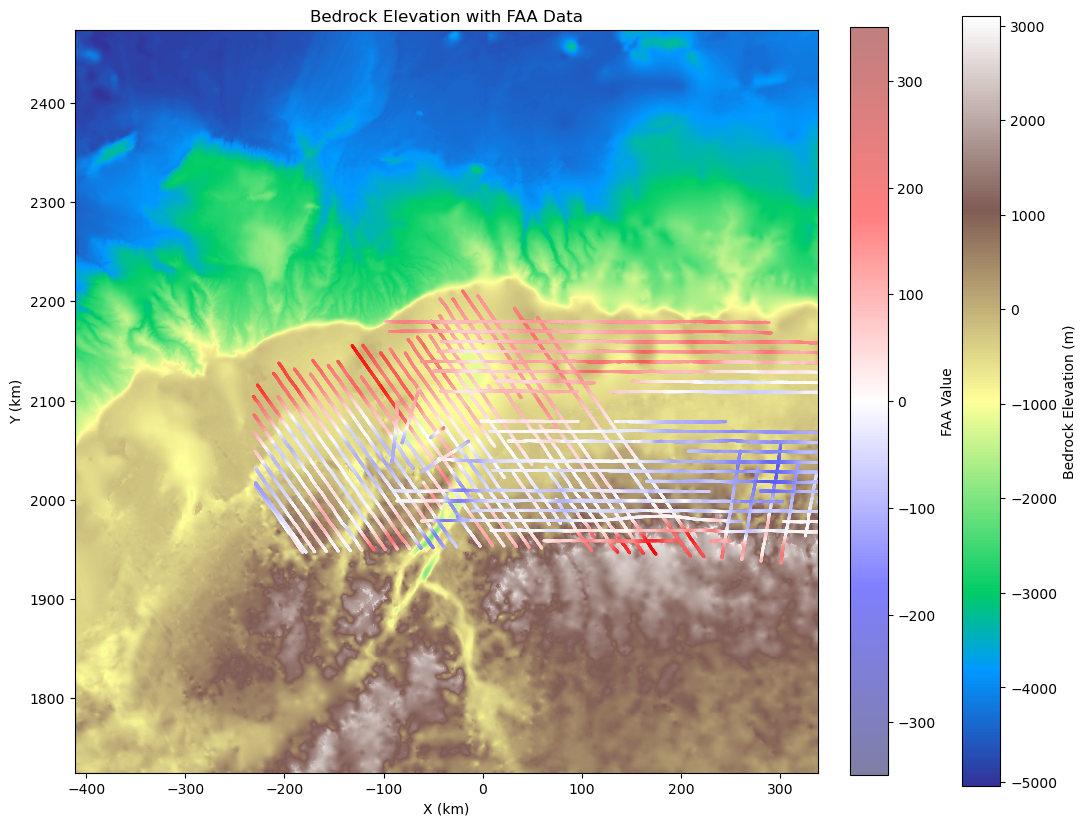

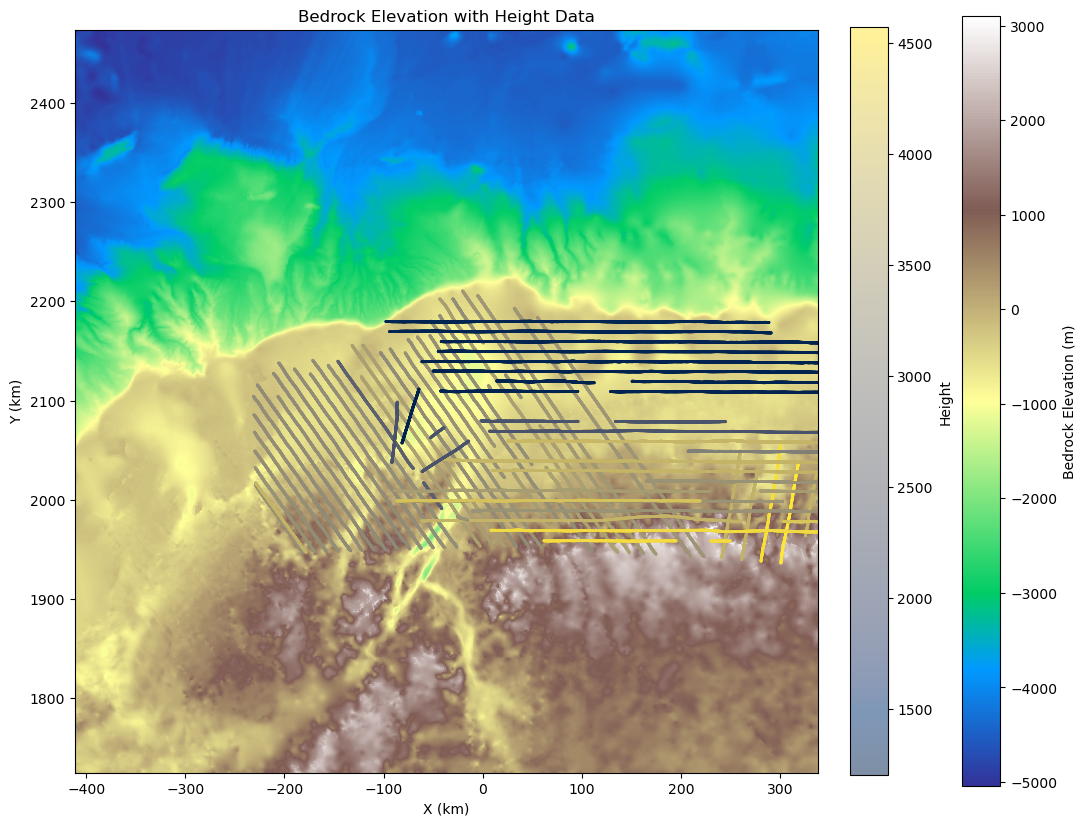

In [14]:
# Filtering out the datapoints near -1000 mGals
mask = np.where(visa["faa"] < -800, False, True)
filtered_grav = visa[mask]


x_km_grav = filtered_grav["x"] / 1000  
y_km_grav = filtered_grav["y"] / 1000
faa_data = filtered_grav["faa"]
height_data = filtered_grav["height"]

x_km = subset["x"] / 1000  # Convert x to kilometers
y_km = subset["y"] / 1000  # Convert y to kilometers
bed = subset["bed"]
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("scaled")

# Plot the bed with pcolormesh first
bed_plot = ax.pcolormesh(x_km, y_km, bed, cmap="terrain", shading="auto")
# Then plot FAA on top
faa_plot = ax.scatter(x_km_grav, y_km_grav, c=faa_data, cmap="seismic", s=1, alpha=0.5, vmin = -350, vmax = 350)

cbar_bed = fig.colorbar(bed_plot, ax=ax, fraction=0.046, pad=0.08)
cbar_bed.set_label("Bedrock Elevation (m)")

# Add colorbar for the faa data
cbar_faa = fig.colorbar(faa_plot, ax=ax, fraction=0.046, pad=0.04)
cbar_faa.set_label("FAA Value")

# Set axis labels and title
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_title("Bedrock Elevation with FAA Data")

plt.ylim(y_km.min(), y_km.max())
plt.xlim(x_km.min(), x_km.max())

plt.show()

fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("scaled")

# Plot the bed with pcolormesh first
bed_plot = ax.pcolormesh(x_km, y_km, bed, cmap="terrain", shading="auto")
# Then plot height
height_plot = ax.scatter(x_km_grav, y_km_grav, c=height_data, cmap="cividis", s=1, alpha=0.5)

cbar_bed = fig.colorbar(bed_plot, ax=ax, fraction=0.046, pad=0.08)
cbar_bed.set_label("Bedrock Elevation (m)")

# Add colorbar for the height data
cbar_height = fig.colorbar(height_plot, ax=ax, fraction=0.046, pad=0.04)
cbar_height.set_label("Height")

# Set axis labels and title
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_title("Bedrock Elevation with Height Data")

plt.ylim(y_km.min(), y_km.max())
plt.xlim(x_km.min(), x_km.max())

plt.show()

## Export data

In [15]:
coarsenedSubset

<xarray.Dataset> Size: 5MB
Dimensions:    (y: 300, x: 300)
Coordinates:
  * x          (x) float64 2kB -4.105e+05 -4.08e+05 ... 3.345e+05 3.37e+05
  * y          (y) float64 2kB 2.473e+06 2.47e+06 ... 1.728e+06 1.726e+06
Data variables:
    mapping    |S1 1B b''
    mask       (y, x) float64 720kB 0.0 0.0 0.0 0.0 0.0 ... 2.0 2.0 2.0 2.0 2.0
    firn       (y, x) float32 360kB 0.0 0.0 0.0 0.0 ... 27.87 27.9 27.91 27.91
    surface    (y, x) float32 360kB 0.0 0.0 0.0 ... 3.274e+03 3.274e+03
    thickness  (y, x) float32 360kB 0.0 0.0 0.0 ... 2.855e+03 2.911e+03
    bed        (y, x) float32 360kB -4.844e+03 -4.815e+03 ... 418.4 363.1
    errbed     (y, x) float32 360kB nan nan nan nan ... 40.12 35.4 39.84 74.44
    source     (y, x) float64 720kB 1.0 1.0 1.0 1.0 1.0 ... 5.0 5.0 5.0 5.0 5.0
    dataid     (y, x) float64 720kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.32 0.0 0.0
    geoid      (y, x) float64 720kB 7.0 7.0 7.0 7.0 7.0 ... 16.0 16.0 16.0 16.0
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [16]:
################################
##### Your work here ###########
filtered_grav.to_csv("WDMLGravData.csv", index = False)
# Had some errors, needed to specify datatypes explicitly.
encoding = {
    "x": {"dtype": "float64"},
    "y": {"dtype": "float64"},
    "mask": {"dtype": "float64"},
    "firn": {"dtype": "float32"},
    "surface": {"dtype": "float32"},
    "thickness": {"dtype": "float32"},
    "bed": {"dtype": "float32"},
    "errbed": {"dtype": "float32"},
    "source": {"dtype": "float64"},
    "dataid": {"dtype": "float64"},
    "geoid": {"dtype": "float64"},
}


coarsenedSubset.to_netcdf("WDMLPhysicalDataCoarsened.nc", encoding = encoding)


## Calculate the Terrain Effect

In [17]:
def upward_continue(grav, height, ds, maxdist):
    xx, yy = np.meshgrid(ds.x, ds.y)
    pred_coords = (xx, yy, np.full(xx.shape, height))
    grav_tmp = grav[grav.height < height]
    equivalent_sources = hm.EquivalentSourcesGB(damping=1, depth=3000, window_size=20e3)
    coordinates = (grav_tmp.x.values, grav_tmp.y.values, grav_tmp.height.values)
    equivalent_sources.fit(coordinates, grav_tmp.faa.values)
    leveled = equivalent_sources.predict(pred_coords)

    dist_msk = vd.distance_mask(coordinates[:2], maxdist, pred_coords[:2])
    masked = np.where(dist_msk, leveled, np.nan)

    return masked

In [18]:
# Upward Continuation to 5000m

height = 5000
maxdist = 5000
continued_grav = upward_continue(filtered_grav, height, coarsenedSubset, maxdist)

### Having upward continued the data, we want to calculate the terrain effect, then save it to a CSV for future use.

#### We start by creating a new dataframe from our upward continued data and saving it.

In [19]:
coarsenedSubset['inv_msk'] = xr.where(coarsenedSubset.mask == 3, True, False)

In [20]:
xx, yy = np.meshgrid(coarsenedSubset.x, coarsenedSubset.y)

# create flattened dataframe of upward continued gravity data
grav_leveled = pd.DataFrame({
    'x': xx.flatten(),
    'y': yy.flatten(),
    'faa': continued_grav.flatten(),
    'height': np.full(continued_grav.flatten().size, height),
    'inv_msk': coarsenedSubset.inv_msk.values.flatten()
})

In [22]:
coarsenedSubset = coarsenedSubset.assign_attrs({'res' : 2500})

In [24]:
terrain_gz = bm_terrain_effect(coarsenedSubset, grav_leveled)

In [25]:
terrain_gz

array([ -99.55883688, -118.42726663, -132.40032849, ...,   82.65239487,
         75.13055018,   59.89012823])

In [26]:
grav_leveled['bouguer'] = grav_leveled['faa'] - terrain_gz

In [28]:
inv_pad = vd.distance_mask(
    data_coordinates = (xx[coarsenedSubset.inv_msk==True], yy[coarsenedSubset.inv_msk==True]),
    coordinates = (grav_leveled.x, grav_leveled.y),
    maxdist = 10e3
)

grav_leveled['inv_pad'] = inv_pad
grav_leveled['inv_msk'] = grav_leveled['inv_msk'].replace(0, False).replace(1, True)

# Crop to ice shelf extent
grav_leveled = grav_leveled[(grav_leveled.x >= int(min(coarsenedSubset.x))) & (grav_leveled.x <= int(max(coarsenedSubset.x))) &
        (grav_leveled.y >= int(min(coarsenedSubset.y))) & (grav_leveled.y <= int(max(coarsenedSubset.y)))]

grav_leveled.to_csv('grav_leveled_5000.csv', index=False)